#Linear Kalman Filter With Control Input Example

###Introduction

This notebook is designed to demonstrate how to use the StateSpace.jl package to execute the Kalman filter for a linear State Space model with control input. The example that has been used here closely follows the one given on "Greg Czerniak's Website". Namely the canonball example on [this page.](http://greg.czerniak.info/guides/kalman1/)   

For those of you that do not need/want the explanation of the model and the code, you can skip right to the end of this notebook where the entire section of code required to run this example is given.

###The Problem

The problem considered here is that of firing a ball from a canon at a given angle and velocity from the canon muzzle. We will assume that measurements of the ball's position are recorded with a camera at a given (constant) interval. The camera has a significant error in its measurement. We also measure the ball's velocity with relatively precise detectors inside the ball.

#####Process Model

The kinematic equations for the system are:

$$
\begin{align}
x(t)   &= x_0 + V_0^x t, \\
V^x(t) &= V_0^x, \\
y(t)   &= y_0 + V_0^y t - \frac{1}{2}gt^2, \\
V^y(t) &= V_0^y - gt,
\end{align}
$$

where $x$ is the position of the ball in the x (horizontal) direction, $y$ is the position of the ball in the y (vertical) direction, $V^x$ is the velocity of the ball in the x (horizontal) direction, $V^y$ is the velocity of the ball in the y (vertical) direction, $t$ is time, $x_0$, $y_0$, $V_0^x$ and $V_0^y$ are the initial x and y postion and velocity of the ball. $g$ is the acceleration due to gravity, 9.81 m/s.

Since the filter is discrete we need to discretize our equations so that we get the value of the current state of the ball in terms of the previous. This leads to the following equations:

$$
\begin{align}
x_n   &= x_{n-1} + V_{n-1}^x \Delta t, \\
V^x_n &= V_{n-1}^x, \\
y_n   &= y_{n-1} + V_{n-1}^y \Delta t - \frac{1}{2}g\Delta t^2, \\
V^y_n &= V_{n-1}^y - g\Delta t.
\end{align}
$$

These equations. Can be written in matrix form as:

$$
\begin{bmatrix}
       x_n   \\[0.3em]
       V^x_n \\[0.3em]
       y_n   \\[0.3em]
       V^y_n 
     \end{bmatrix}
     = 
     \begin{bmatrix}
       1 & \Delta t & 0 & 0        \\[0.3em]
       0 & 1        & 0 & 0        \\[0.3em]
       0 & 0        & 1 & \Delta t \\[0.3em]
       0 & 0        & 0 & 1
     \end{bmatrix}
     \begin{bmatrix}
       x_{n-1}   \\[0.3em]
       V^x_{n-1} \\[0.3em]
       y_{n-1}   \\[0.3em]
       V^y_{n-1} 
     \end{bmatrix}
     +
     \begin{bmatrix}
       0 & 0 & 0 & 0        \\[0.3em]
       0 & 0 & 0 & 0        \\[0.3em]
       0 & 0 & 1 & 0 \\[0.3em]
       0 & 0 & 0 & 1
     \end{bmatrix}
     \begin{bmatrix}
       0   \\[0.3em]
       0 \\[0.3em]
       -\frac{1}{2}g\Delta t^2   \\[0.3em]
       -g\Delta t 
     \end{bmatrix},
$$

Which is in the form:
$$
\mathbf{x}_n = \mathbf{A}\mathbf{x}_{n-1} + \mathbf{B}\mathbf{u}_n,
$$

where $\mathbf{x}_n$ is the state vector at the current time step, $\mathbf{A}$ is the process matrix, $\mathbf{B}$ is the control matrix and $\mathbf{u}_n$ is the control input vector.

#####Observation Model

We assume that we measure the position and velocity of the canonball directly and hence the observation (emission) matrix is the identity matrix, namely:

$$
\begin{bmatrix}
       1 & 0 & 0 & 0        \\[0.3em]
       0 & 1 & 0 & 0        \\[0.3em]
       0 & 0 & 1 & 0 \\[0.3em]
       0 & 0 & 0 & 1
\end{bmatrix}
$$

###Setting up the problem
First we'll import the required modules

In [5]:
using StateSpace
using Distributions
using Gadfly
using Colors

#####Generate noisy observations
In this section we will generate the noisy observations using the kinematic equations defined above in their continuous form.   

The first thing to do is to set the parameters of the model

In [6]:
elevation_angle = 45.0 #Angle above the (horizontal) ground
muzzle_speed = 100.0 #Speed at which the canonball leaves the muzzle
initial_velocity = [muzzle_speed*cos(deg2rad(elevation_angle)), muzzle_speed*sin(deg2rad(elevation_angle))] #initial x and y components of the velocity
gravAcc = 9.81 #gravitational acceleration
initial_location = [0.0, 0.0] # initial position of the canonball
Δt = 0.1 #time between each measurement

0.1

Next we'll define the kinematic equations of the model as functions in Julia (we don't care about the horizontal velocity component because it's constant).

In [7]:
x_pos(x0::Float64, Vx::Float64, t::Float64) = x0 + Vx*t
y_pos(y0::Float64, Vy::Float64, t::Float64, g::Float64) = y0 + Vy*t - (g * t^2)/2
velocityY(Vy::Float64, t::Float64, g::Float64) = Vy - g * t

velocityY (generic function with 1 method)

Let's now set the variances of the noise for the position and velocity observations. We'll make the positional noise quite big.

In [8]:
x_pos_var = 200.0
y_pos_var = 200.0
Vx_var = 1.0
Vy_var = 1.0

1.0

Now we will preallocate the arrays to store the true values and the noisy measurements. Then we will create the measurements in a `for` loop

In [9]:
#Set the number of observations and preallocate vectors to store true and noisy measurement values
numObs = 145
x_pos_true = Vector{Float64}(numObs)
x_pos_obs = Vector{Float64}(numObs)
y_pos_true = Vector{Float64}(numObs)
y_pos_obs = Vector{Float64}(numObs)

Vx_true = Vector{Float64}(numObs)
Vx_obs = Vector{Float64}(numObs)
Vy_true = Vector{Float64}(numObs)
Vy_obs = Vector{Float64}(numObs)

#Generate the data (true values and noisy observations)
for i in 1:numObs
    x_pos_true[i] = x_pos(initial_location[1], initial_velocity[1], (i-1)*Δt)
    y_pos_true[i] = y_pos(initial_location[2], initial_velocity[2], (i-1)*Δt, gravAcc)
    Vx_true[i] = initial_velocity[1]
    Vy_true[i] = velocityY(initial_velocity[2], (i-1)*Δt, gravAcc)

    x_pos_obs[i] = x_pos_true[i] + randn() * sqrt(x_pos_var)
    y_pos_obs[i] = y_pos_true[i] + randn() * sqrt(y_pos_var)
    Vx_obs[i] = Vx_true[i] + randn() * sqrt(Vx_var)
    Vy_obs[i] = Vy_true[i] + randn() * sqrt(Vy_var)
end
#Create the observations vector for the Kalman filter
observations = [x_pos_obs Vx_obs y_pos_obs Vy_obs]'

4x145 Array{Float64,2}:
  27.5362  17.4128   8.21901  23.4534  …  1031.92    1017.46    1008.86    
  70.6357  70.5231  69.0466   71.7508       72.5959    71.8064    71.1393  
 -13.8262  14.8338  -3.021    18.6249       11.4074    20.4072    -0.204891
  70.764   69.6419  68.9981   67.7001      -67.6705   -71.0606   -68.423   

The final step in the code block above just puts all of the observations in a single array. Notice that we transpose the array to make sure that the dimensions are consistent with the StateSpace.jl convention. (Each observation is represented by a single column).

#####Define Kalman Filter Parameters

Now we can set the parameters for the process and observation model as defined above. We also set values for the corresponding covariance matrices. Because we're very sure about the process model, we set the process covariance to be very small. The observations can be set to have a higher variance but you can play about with these parameters.   
NOTE: Be carefull about setting the diagonal values to zero, these can result in calculation errors downstream in the matrix calculations - rather the values can be set to be very small.

In [10]:
process_matrix = [[1.0, Δt, 0.0, 0.0] [0.0, 1.0, 0.0, 0.0] [0.0, 0.0, 1.0, Δt] [0.0, 0.0, 0.0, 1.0]]'
process_covariance = 0.01*eye(4)
observation_matrix = eye(4)
observation_covariance = 0.2*eye(4)
control_matrix = [[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 1.0, 0.0] [0.0, 0.0, 0.0, 1.0]]
control_input = [0.0, 0.0, -(gravAcc * Δt^2)/2, -(gravAcc * Δt)]

#Create an instance of the LKF with the control inputs
linCISMM = LinearGaussianCISSM(process_matrix, process_covariance, observation_matrix, observation_covariance, control_matrix, control_input)

StateSpace.LinearGaussianCISSM{Float64}(4x4 Array{Float64,2}:
 1.0  0.1  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.1
 0.0  0.0  0.0  1.0,4x4 Array{Float64,2}:
 0.01  0.0   0.0   0.0 
 0.0   0.01  0.0   0.0 
 0.0   0.0   0.01  0.0 
 0.0   0.0   0.0   0.01,4x4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0,4x4 Array{Float64,2}:
 0.2  0.0  0.0  0.0
 0.0  0.2  0.0  0.0
 0.0  0.0  0.2  0.0
 0.0  0.0  0.0  0.2,4x4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0,[0.0,0.0,-0.04905000000000001,-0.9810000000000001])

#####Initial Guess 
Now we can make an initial guess for the state of the system (position and velocity). We've purposely set the y coordinate of the initial value way off. This is to show how quickly the Kalman filter can converge to the correct solution. This isn't generally the case. It really depends on how good you model is and also the covariance matrix that you assign to the process/observation models. In this case, if you increase the observation variance (i.e. `observation_covariance = 10*eye(4)` say) then you'll see that it takes the Kalman filter longer to converge to the correct value. 

In [11]:
initial_guess_state = [0.0, initial_velocity[1], 500.0, initial_velocity[2]]
initial_guess_covariance = eye(4)
initial_guess = MvNormal(initial_guess_state, initial_guess_covariance)

FullNormal(
dim: 4
μ: [0.0,70.71067811865476,500.0,70.71067811865474]
Σ: 4x4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0
)


#####Perform Linear Kalman Filter Algorithm
Now we have all of the parameters:
1. noisy observations
2. process (transition) and observation (emission) model paramaters
3. initial guess of state   

We can use the Kalman Filter to predict the true underlying state (The position - and velocity - of the canonball).

In [12]:
filtered_state = filter(linCISMM, observations, initial_guess)

SmoothedState{Float64}


145 estimates of 4-D process from 4-D observations
Log-likelihood: -689522.8651180617


###Plot Results
Now we can plot the results to see how well the Kalman Filter predicts the true position of the ball.

in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:241
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:241
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:248
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:248
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:248
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:251
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:251
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:251
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compos

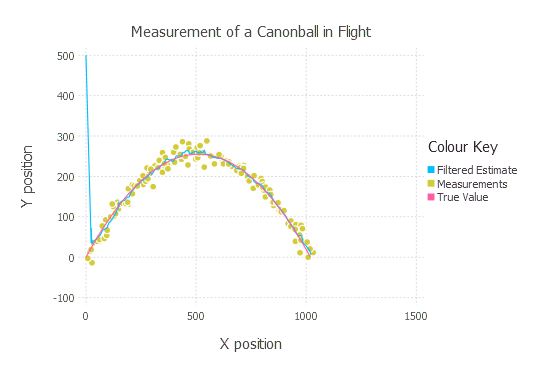

task.jl:447
while loading C:\Users\jonathan\.julia\v0.4\IJulia\src\kernel.jl, in expression starting on line 31
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in realize_brute_force at C:\Users\jonathan\.julia\v0.4\Compose\src\table.jl:352
 in realize at C:\Users\jonathan\.julia\v0.4\Compose\src\table.jl:378
 in drawpart at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:447
 in draw at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:404
 in writemime at C:\Users\jonathan\.julia\v0.4\Gadfly\src\Gadfly.jl:845
 in sprint at iostream.jl:211
 in display_dict at C:\Users\jonathan\.julia\v0.4\IJulia\src\execute_request.jl:39
 in execute_request_0x535c5df2 at C:\Users\jonathan\.julia\v0.4\IJulia\src\execute_request.jl:212
 in eventloop at C:\Users\jonathan\.julia\v0.4\IJulia\src\IJulia.jl:144
 in anonymous at task.jl:447
while loading C:\Users\jonathan\.julia\v0.4\IJulia\src\kernel.jl, in expression starting on line 31
 in depwarn at deprecated.jl:73
 in call at d

In [13]:
x_filt = Vector{Float64}(numObs)
y_filt = Vector{Float64}(numObs)
for i in 1:numObs
    current_state = filtered_state.state[i]
    x_filt[i] = current_state.μ[1]
    y_filt[i] = current_state.μ[3]
end

n = 3
getColors = distinguishable_colors(n, Color[LCHab(70, 60, 240)],
                                   transform=c -> deuteranopic(c, 0.5),
                                   lchoices=Float64[65, 70, 75, 80],
                                   cchoices=Float64[0, 50, 60, 70],
                                   hchoices=linspace(0, 330, 24))

cannonball_plot = plot(
    layer(x=x_pos_true, y=y_pos_true, Geom.line, Theme(default_color=getColors[3])),
    layer(x=[initial_guess_state[1]; x_filt], y=[initial_guess_state[3]; y_filt], Geom.line, Theme(default_color=getColors[1])),
    layer(x=x_pos_obs, y=y_pos_obs, Geom.point, Theme(default_color=getColors[2])),
    Guide.xlabel("X position"), Guide.ylabel("Y position"),
    Guide.manual_color_key("Colour Key",["Filtered Estimate", "Measurements","True Value "],[getColors[1],getColors[2],getColors[3]]),
    Guide.title("Measurement of a Canonball in Flight")
    )

Looking for the full code without having to read through the entire document? We'll here you go :)

in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:241
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:241
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:248
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:248
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:248
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:251
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:251
in call at C:\Users\jonathan\.julia\v0.4\Compose\src\svg.jl:251
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:362
in compose at C:\Users\jonathan\.julia\v0.4\Compos

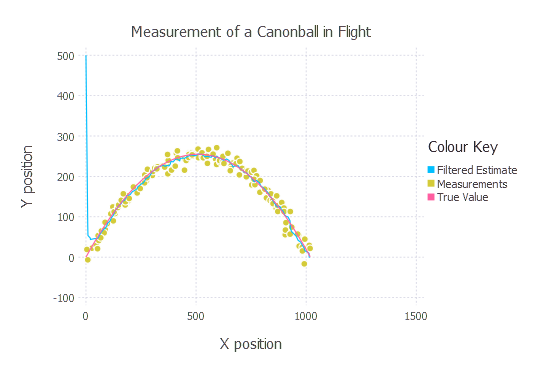

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in realize_brute_force at C:\Users\jonathan\.julia\v0.4\Compose\src\table.jl:352
 in realize at C:\Users\jonathan\.julia\v0.4\Compose\src\table.jl:378
 in drawpart at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:447
 in draw at C:\Users\jonathan\.julia\v0.4\Compose\src\container.jl:404
 in writemime at C:\Users\jonathan\.julia\v0.4\Gadfly\src\Gadfly.jl:845
 in sprint at iostream.jl:211
 in display_dict at C:\Users\jonathan\.julia\v0.4\IJulia\src\execute_request.jl:39
 in execute_request_0x535c5df2 at C:\Users\jonathan\.julia\v0.4\IJulia\src\execute_request.jl:212
 in eventloop at C:\Users\jonathan\.julia\v0.4\IJulia\src\IJulia.jl:144
 in anonymous at task.jl:447
while loading C:\Users\jonathan\.julia\v0.4\IJulia\src\kernel.jl, in expression starting on line 31
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in realize_brute_force at C:\Users\jonathan\.julia\v0.4\Compose\src\table.jl:352
 in realize at

In [1]:
using StateSpace
using Distributions
using Gadfly
using Colors

#Set the Parameters
elevation_angle = 45.0
muzzle_speed = 100.0 
initial_velocity = [muzzle_speed*cos(deg2rad(elevation_angle)), muzzle_speed*sin(deg2rad(elevation_angle))]
gravAcc = 9.81
initial_location = [0.0, 0.0]
Δt = 0.1

#Functions describing the position of canonball
x_pos(x0::Float64, Vx::Float64, t::Float64) = x0 + Vx*t
y_pos(y0::Float64, Vy::Float64, t::Float64, g::Float64) = y0 + Vy*t - (g * t^2)/2
#Function to describe the evolution of the velocity in the vertical direction
velocityY(Vy::Float64, t::Float64, g::Float64) = Vy - g * t

#Give variances of the observation noise for the position and velocity
x_pos_var = 200.0
y_pos_var = 200.0
Vx_var = 1.0
Vy_var = 1.0

#Set the number of observations and preallocate vectors to store true and noisy measurement values
numObs = 145
x_pos_true = Vector{Float64}(numObs)
x_pos_obs = Vector{Float64}(numObs)
y_pos_true = Vector{Float64}(numObs)
y_pos_obs = Vector{Float64}(numObs)

Vx_true = Vector{Float64}(numObs)
Vx_obs = Vector{Float64}(numObs)
Vy_true = Vector{Float64}(numObs)
Vy_obs = Vector{Float64}(numObs)

#Generate the data (true values and noisy observations)
for i in 1:numObs
    x_pos_true[i] = x_pos(initial_location[1], initial_velocity[1], (i-1)*Δt)
    y_pos_true[i] = y_pos(initial_location[2], initial_velocity[2], (i-1)*Δt, gravAcc)
    Vx_true[i] = initial_velocity[1]
    Vy_true[i] = velocityY(initial_velocity[2], (i-1)*Δt, gravAcc)

    x_pos_obs[i] = x_pos_true[i] + randn() * sqrt(x_pos_var)
    y_pos_obs[i] = y_pos_true[i] + randn() * sqrt(y_pos_var)
    Vx_obs[i] = Vx_true[i] + randn() * sqrt(Vx_var)
    Vy_obs[i] = Vy_true[i] + randn() * sqrt(Vy_var)
end
#Create the observations vector for the Kalman filter
observations = [x_pos_obs Vx_obs y_pos_obs Vy_obs]'

#Describe the system parameters
process_matrix = [[1.0, Δt, 0.0, 0.0] [0.0, 1.0, 0.0, 0.0] [0.0, 0.0, 1.0, Δt] [0.0, 0.0, 0.0, 1.0]]'
process_covariance = 0.01*eye(4)
observation_matrix = eye(4)
observation_covariance = 0.2*eye(4)
control_matrix = [[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 1.0, 0.0] [0.0, 0.0, 0.0, 1.0]]
control_input = [0.0, 0.0, -(gravAcc * Δt^2)/2, -(gravAcc * Δt)]

#Create an instance of the LKF with the control inputs
linCISMM = LinearGaussianCISSM(process_matrix, process_covariance, observation_matrix, observation_covariance, control_matrix, control_input)

#Set Initial Guess
initial_guess_state = [0.0, initial_velocity[1], 500.0, initial_velocity[2]]
initial_guess_covariance = eye(4)
initial_guess = MvNormal(initial_guess_state, initial_guess_covariance)

#Execute Kalman Filter
filtered_state = filter(linCISMM, observations, initial_guess)

#Plot Filtered results
x_filt = Vector{Float64}(numObs)
y_filt = Vector{Float64}(numObs)
for i in 1:numObs
    current_state = filtered_state.state[i]
    x_filt[i] = current_state.μ[1]
    y_filt[i] = current_state.μ[3]
end

n = 3
getColors = distinguishable_colors(n, Color[LCHab(70, 60, 240)],
                                   transform=c -> deuteranopic(c, 0.5),
                                   lchoices=Float64[65, 70, 75, 80],
                                   cchoices=Float64[0, 50, 60, 70],
                                   hchoices=linspace(0, 330, 24))

cannonball_plot = plot(
    layer(x=x_pos_true, y=y_pos_true, Geom.line, Theme(default_color=getColors[3])),
    layer(x=[initial_guess_state[1]; x_filt], y=[initial_guess_state[3]; y_filt], Geom.line, Theme(default_color=getColors[1])),
    layer(x=x_pos_obs, y=y_pos_obs, Geom.point, Theme(default_color=getColors[2])),
    Guide.xlabel("X position"), Guide.ylabel("Y position"),
    Guide.manual_color_key("Colour Key",["Filtered Estimate", "Measurements","True Value "],[getColors[1],getColors[2],getColors[3]]),
    Guide.title("Measurement of a Canonball in Flight")
    )